In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score , roc_curve, auc, plot_roc_curve, plot_precision_recall_curve
from sklearn import preprocessing
from collections import Counter
from verstack import LGBMTuner
import pickle
import os
import sys
import mlflow
from mlflow.tracking import MlflowClient

def load_data():
    # Read ResultFraudTest_2023-02-23-16-05.xlsx and create a dataframe
    df = pd.read_excel('data/ResultFraudTest_2023-02-23-16-05.xlsx')
    return df

In [56]:
# Function to show the distribution of classes
def distribution_classes(df):
    y_counts = df['is_fraud'].value_counts().to_frame('count_y_classes')
    y_counts['percentage_y_classes'] = y_counts['count_y_classes'] / y_counts['count_y_classes'].sum()
    print(y_counts)
    sns.countplot(x='is_fraud', data=df, palette='hls')
    return y_counts

In [57]:
# Function to extract only the columns that will be used in the model  
def get_variables(df):
    columns = ['calculation','count_zip','count_trans_person','is_fraud'] 
    df = df[columns]
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1] 
    return X, y

# Function to calculate the scale_pos_weight (class_weight parameter in algorithm)
def calc_pos_weight(y):
    counter=Counter(y)
    print(counter)
    scale_pos_weight = counter[0] / counter[1]
    print('scale_pos_weight: %.3f' % scale_pos_weight)
    return scale_pos_weight

In [58]:
# Function to create the training and test sets
def make_train_test_split(x,y):
    # Create the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=101)
    print(f'X train set size: {X_train.shape};'f'\nX test set size: {X_test.shape};', f'\ny train set size: {y_train.shape};' f'\ny test set size: {y_test.shape};')
    return X_train, X_test, y_train, y_test

In [59]:
# Function to calcule the metrics to be used
def eval_metrics(y_test,y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1score = f1_score(y_test, y_pred)
    return acc, precision, recall, F1score, mse, mae

# Function to report metrics
def report(params,acc,precision,recall,F1score,mse,mae):
    print(f'Best parameters: {params}')
    print(f'Accuracy of LightGBM classifier is: {acc}')
    print(f'Precision Score of LightGBM classifier is: {precision}')
    print(f'Recall Score of LightGBM classifier is: {recall}')
    print(f'F1 Score of LightGBM classifier is: {F1score}')
    print(f'mse: {mse}')
    print(f'mae: {mae}')

In [60]:
# Function to save the model
def save_best_estimator(estimator, path= 'models',pFile = 'fraud_model.pickle'):
    if not os.path.exists('models'):
        os.makedirs('models')
    with open(os.path.join(path, pFile), 'wb') as file:
        pickle.dump(estimator, file)
    

In [61]:
# Function to load the model 
def load_best_estimator(path='models', pFile='estimator.pickle'):
    if not os.path.exists(path):
        return None
    with open(os.path.join(path, pFile), "rb") as file:
        estimator = pickle.load(file)
    return estimator

In [62]:
# Function to do the manual training of the data, to extract some parameters to be compared
def manual_train_estimator(df):
    mlflow.lightgbm.autolog(disable=True)
    n_leaves = np.linspace(20, 300, 20)
    r_alpha = np.linspace(0.0001, 0.5, 20)
    r_lambda = np.linspace(0.0001, 0.5, 20)
    X, y = get_variables(df)
    X_train, X_test, y_train, y_test = make_train_test_split(X,y)
    scale_pos_weight = calc_pos_weight(y)
    # Create the model
    lst = []
    for i,k,j in zip(n_leaves, r_alpha, r_lambda):
        model = lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight, num_leaves=int(i),reg_alpha= k,reg_lambda = j,boosting_type='gbdt',n_jobs=-1,random_state=101)
        # Fitting the model to the training data
        model.fit(X_train, y_train)
        # Making predictions
        y_pred = model.predict(X_test) 
        params = model.get_params()
        # Model evaluation
        acc, precision, recall, score_f1, mse, mae = eval_metrics(y_test,y_pred)
        lst.append([acc,precision,recall,score_f1,mse,mae])
    return lst
        

In [63]:
# Fuction to tune the hyperparameters of the LightGBM algorithm
def get_tuned_params(df):
    mlflow.lightgbm.autolog(disable=True)
    X, y = get_variables(df)
    X_train, X_test, y_train, y_test = make_train_test_split(X,y)
    scale_pos_weight = calc_pos_weight(y)
    
    # Create the model
    tuner=LGBMTuner(scale_pos_weight=scale_pos_weight,metric='f1', trials=1000)
    
    # Fitting the model to the training data
    tuner.fit(X_train, y_train)
    
    # Making predictions
    y_pred = tuner.predict(X_test) 
    
    # Model evaluation
    acc, precision, recall, score_f1, mse, mae = eval_metrics(y_test,y_pred)
    report(tuner.best_params,acc,precision,recall,score_f1,mse,mae)
    
    return tuner.best_params

In [64]:
# Fuction to train the LightGBM algorithm with the best hyperparameters
def best_train_estimator(df,tuner_model):

    X, y = get_variables(df)
    X_train, X_test, y_train, y_test = make_train_test_split(X,y)
    scale_pos_weight = calc_pos_weight(y)
    
    # Create the model
    params = tuner_model
    model = lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight,boosting_type='gbdt',n_jobs=-1, **params)
    
    # Fitting the model to the training data
    model.fit(X_train, y_train)
    
    # Making predictions
    y_pred = model.predict(X_test) 
    
    # Model evaluation
    acc, precision, recall, score_f1, mse, mae = eval_metrics(y_test,y_pred)
    report(model.get_params(),acc,precision,recall,score_f1,mse,mae)
    
    # Plot graphs
    precision_recall_curve_plot(model,X_test,y_test)
    roc_curve_plot(model,X_test,y_test)
    
    # Save model results
    save_best_estimator(model)
    model.booster_.save_model('models/fraud_model.txt')
    model.booster_.save_model('models/fraud_model.json')
    
    return y_test,y_pred,model,acc,precision,recall,score_f1,mse,mae

In [65]:
# Fuction to plot the list with the Accuracy, Precision, Recall, F1 Score, MSE and MAE metrics of the model, using seaborn and save the image as png file
def plot_metrics(metric):
    metric = pd.DataFrame(metric)
    metric.columns = ['Accuracy','Precision','Recall','F1 Score','MSE','MAE']
    metric.plot(figsize=(16,12), title='Metrics for each manual training',marker='o',markersize=3)
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.xlabel('Manual Train')
    plt.ylabel('Metrics Value')
    plt.xticks(np.arange(0, 20, 1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend(title='Metrics')
    if not os.path.exists('images'):
        os.makedirs('images')
    plt.savefig('images/metrics.png',facecolor='white', transparent=False)
    plt.show()


In [66]:
# Function to plot the confusion matrix
def confusion_matrix_plot(y_test,y_pred):
    cfm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['Not Fraud', 'Fraud'])
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(12,12))
    cm_display.plot(ax=ax)
    if not os.path.exists('images'):
        os.makedirs('images')
    plt.savefig('images/confusion_matrix.png',facecolor='white', transparent=False)
    plt.show()
    return cfm


In [67]:
# Function to plot the roc curve
def roc_curve_plot(model,X_test,y_test):
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(16,12))
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plot_roc_curve(model,X_test,y_test,ax=ax)
    if not os.path.exists('images'):
        os.makedirs('images')
    plt.savefig('images/roc_curve.png',facecolor='white', transparent=False)
    plt.show()

In [68]:
#Function to plot the Precision - Recall curve
def precision_recall_curve_plot(model,X_test, y_test):
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(16,12))
    pprc = plot_precision_recall_curve(model,X_test,y_test,ax=ax)
    if not os.path.exists('images'):
        os.makedirs('images')
    plt.savefig('images/precision_recall_curve.png',facecolor='white', transparent=False)
    plt.show()


X train set size: (36240, 3);
X test set size: (17850, 3); 
y train set size: (36240,);
y test set size: (17850,);
Counter({0: 53899, 1: 191})
scale_pos_weight: 282.194


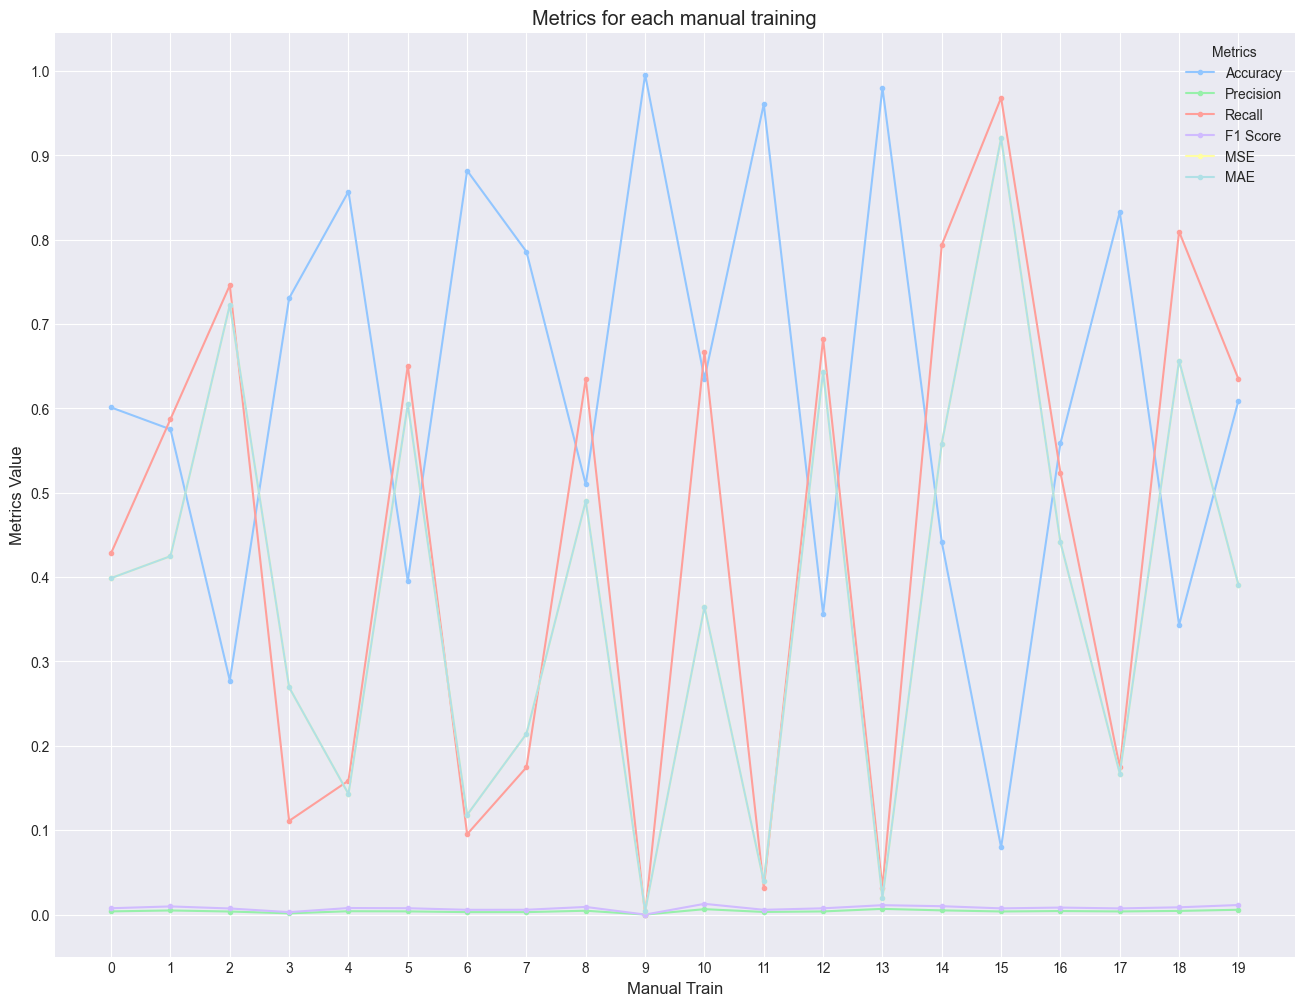

In [69]:
          
df = load_data()
metric = manual_train_estimator(df)
plot_metrics(metric)

X train set size: (36240, 3);
X test set size: (17850, 3); 
y train set size: (36240,);
y test set size: (17850,);
Counter({0: 53899, 1: 191})
scale_pos_weight: 282.194

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 1000 trials
     .. Evaluation metric: f1 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.020854694612631428
     .. Evaluation score (greater-better): f1: 0.2222222222222222
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.023171494452480998
     .. Evaluation score (greater-better): f1: 0.11764705882352941
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.02164782004191422
     .. Evaluation score (greater-better): f1: 0.17142857142857143
 ...........

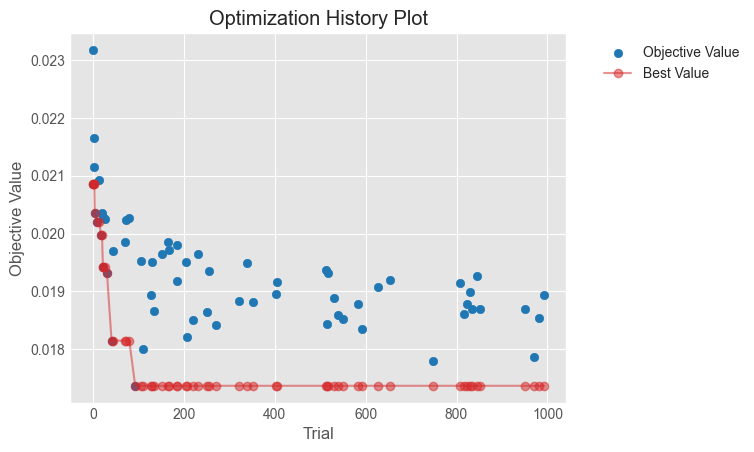

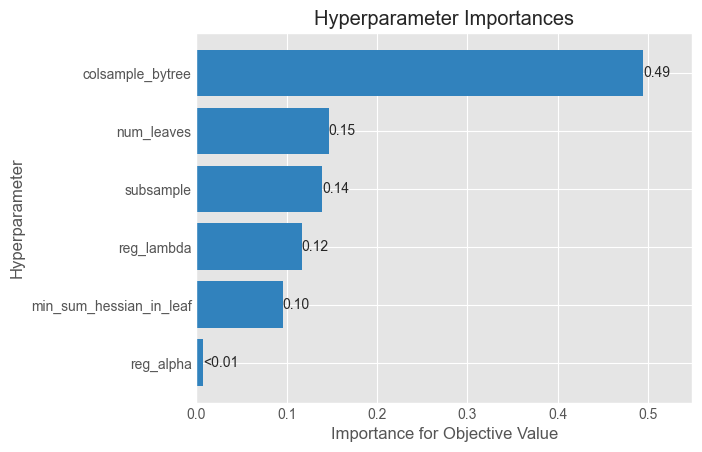

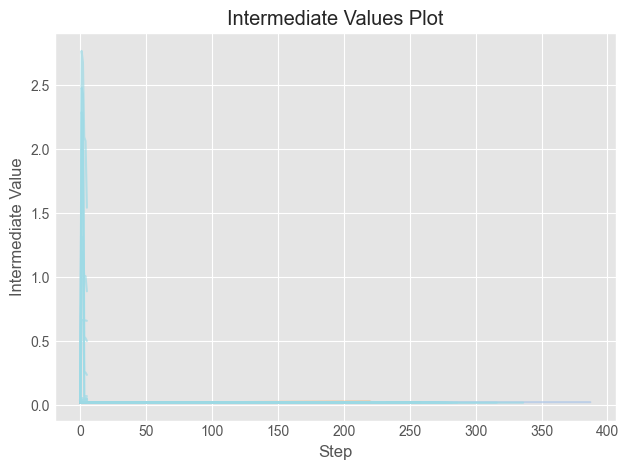

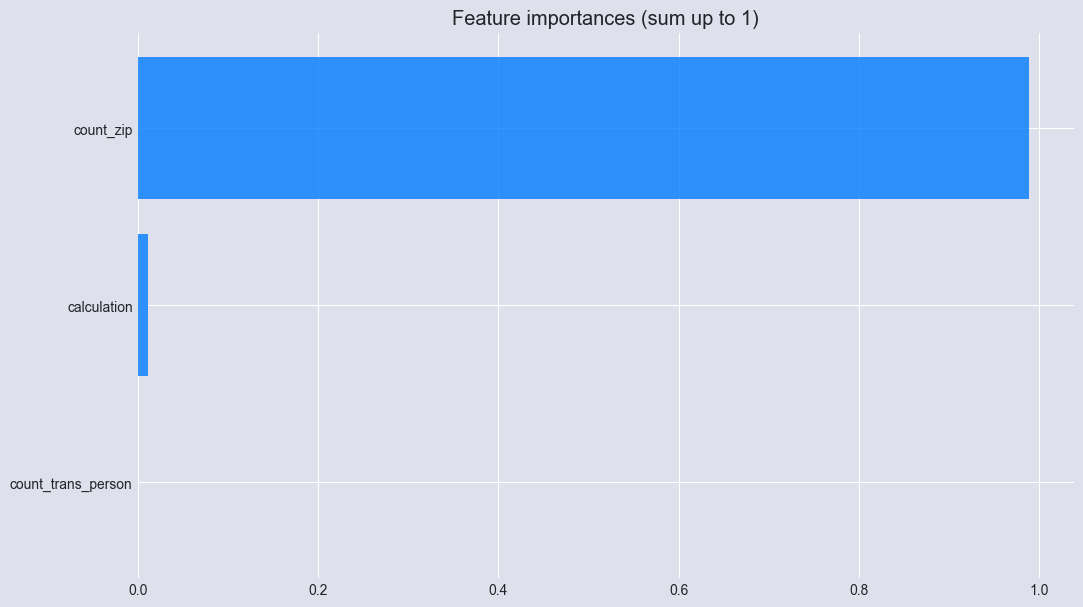


     . Optuna hyperparameters optimization finished
     .. Best trial number:93    |     log_loss:         0.017371624676676488
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:   19   |     f1:          0.06060606060606061

Time elapsed for fit execution: 1 min 21.323 sec
Best parameters: {'task': 'train', 'learning_rate': 0.03, 'num_leaves': 87, 'colsample_bytree': 0.7868908575086677, 'subsample': 0.7393632629952507, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.3802044031450833e-06, 'reg_lambda': 6.19931411704094e-08, 'min_split_gain': 0.0, 'zero_as_missing': False, 'max_bin': 255, 'min_data_in_bin': 3, 'random_state': 42, 'device_type': 'cpu', 'num_classes': 1, 'objective': 'binary', 'metric': 'binary_logloss', 'num_threads': 10, 'min_sum_hessian_in_leaf': 0.0037615156239126702, 'n_estimators': 19}
Accuracy of LightGBM classifier is: 0.9965266106442577
Precision Scor

In [70]:
# Tuning the hyperparameters of the LightGBM algorithm
tuned_params = get_tuned_params(df)

In [71]:
# Fuction to run, save and register the model
def mlflow_model(exp_name,df,tuned_params,main_path):
    client = MlflowClient()
    mlflow.set_experiment(exp_name)
    exp = client.get_experiment_by_name(exp_name)
    # Absolute 
    img_path = os.path.join(main_path, 'images')
    # Start a new run in the experiment and track 
    with mlflow.start_run(experiment_id=exp.experiment_id):
        #Set model description
        mlflow.set_tag('mlflow.note.content',"Model to predict fraud transactions")   
        mlflow.lightgbm.autolog(registered_model_name=exp_name,log_model_signatures = True) 
        y_test,y_pred,model,acc,precision,recall,score_f1,mse,mae = best_train_estimator(df,tuned_params)
        mlflow.log_metric("Accuracy",acc)
        mlflow.log_metric("Precision",precision)
        mlflow.log_metric("Recall",recall)
        mlflow.log_metric("F1 Score",score_f1)
        mlflow.log_metric("MSE",mse)
        mlflow.log_metric("MAE",mae)
        confusion_matrix_plot(y_test,y_pred)
        mlflow.log_artifact(img_path)
        autolog_run= mlflow.active_run()
        autolog_run_id = mlflow.last_active_run().info.run_id
        # mlflow.register_model(f"runs:/{autolog_run_id}",exp_name)
    mlflow.end_run()
    return autolog_run_id

In [72]:
# Function to change the stage of the model
def change_stage(exp_name,version,stage):
    client = MlflowClient()
    client.update_model_version(name=exp_name,version=version ,description="Model to predict fraud transactions")
    client.transition_model_version_stage(
            name=exp_name,
            version=version,
            # Staging|Archived|Production|None
            stage=stage)

In [73]:
# Fuction to make predictions using the model
def predict(df,exp_name,version):
    X, y = get_variables(df)
    X_train, X_test, y_train, y_test = make_train_test_split(X,y)
    model_name = exp_name
    model_version = version
    model = mlflow.pyfunc.load_model(
        model_uri=f"models:/{model_name}/{model_version}")
    return model.predict(X_test[0:1000])

2023/03/23 15:16:18 INFO mlflow.tracking.fluent: Experiment with name 'LightGBM_autolog_Fraud_Model' does not exist. Creating a new experiment.


X train set size: (36240, 3);
X test set size: (17850, 3); 
y train set size: (36240,);
y test set size: (17850,);
Counter({0: 53899, 1: 191})
scale_pos_weight: 282.194
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0037615156239126702, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0037615156239126702
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Successfully registered model 'LightGBM_autolog_Fraud_Model'.
2023/03/23 15:16:21 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LightGBM_autolog_Fraud_Model, version 1
Created version '1' of model 'LightGBM_autolog_Fraud_Model'.


Best parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7868908575086677, 'importance_type': 'split', 'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 19, 'n_jobs': -1, 'num_leaves': 87, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 2.3802044031450833e-06, 'reg_lambda': 6.19931411704094e-08, 'silent': 'warn', 'subsample': 0.7393632629952507, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'scale_pos_weight': 282.1937172774869, 'task': 'train', 'bagging_freq': 1, 'verbosity': -1, 'zero_as_missing': False, 'max_bin': 255, 'min_data_in_bin': 3, 'device_type': 'cpu', 'num_classes': 1, 'metric': 'binary_logloss', 'num_threads': 10, 'min_sum_hessian_in_leaf': 0.0037615156239126702}
Accuracy of LightGBM classifier is: 0.7988795518207283
Precision Score of LightGBM classifier is: 0.00698909700866648
Recall Score of LightGBM classifier is: 0.3968253968253968
F1 Score of L

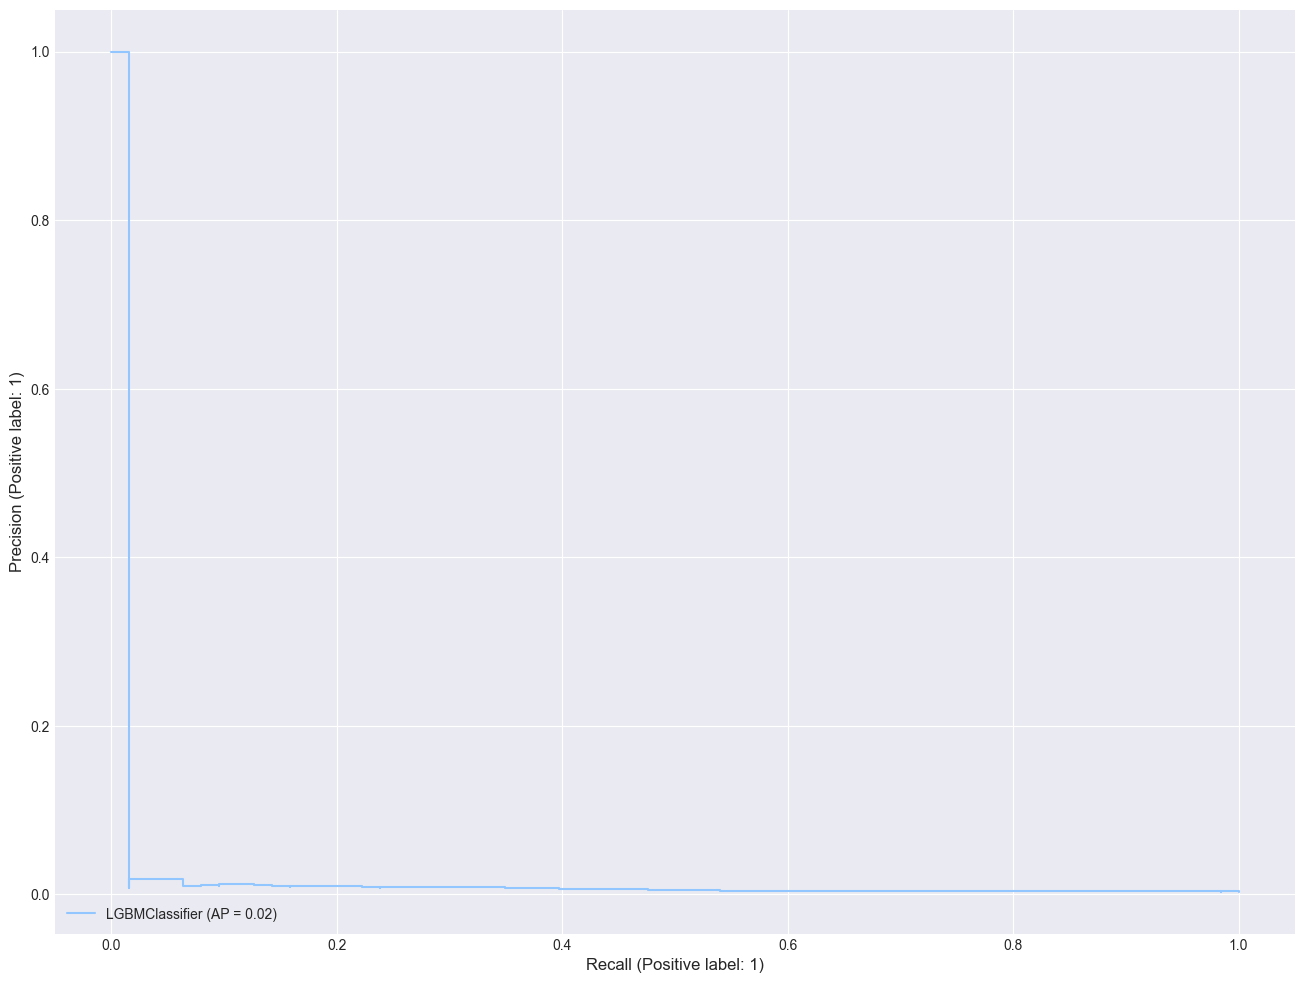

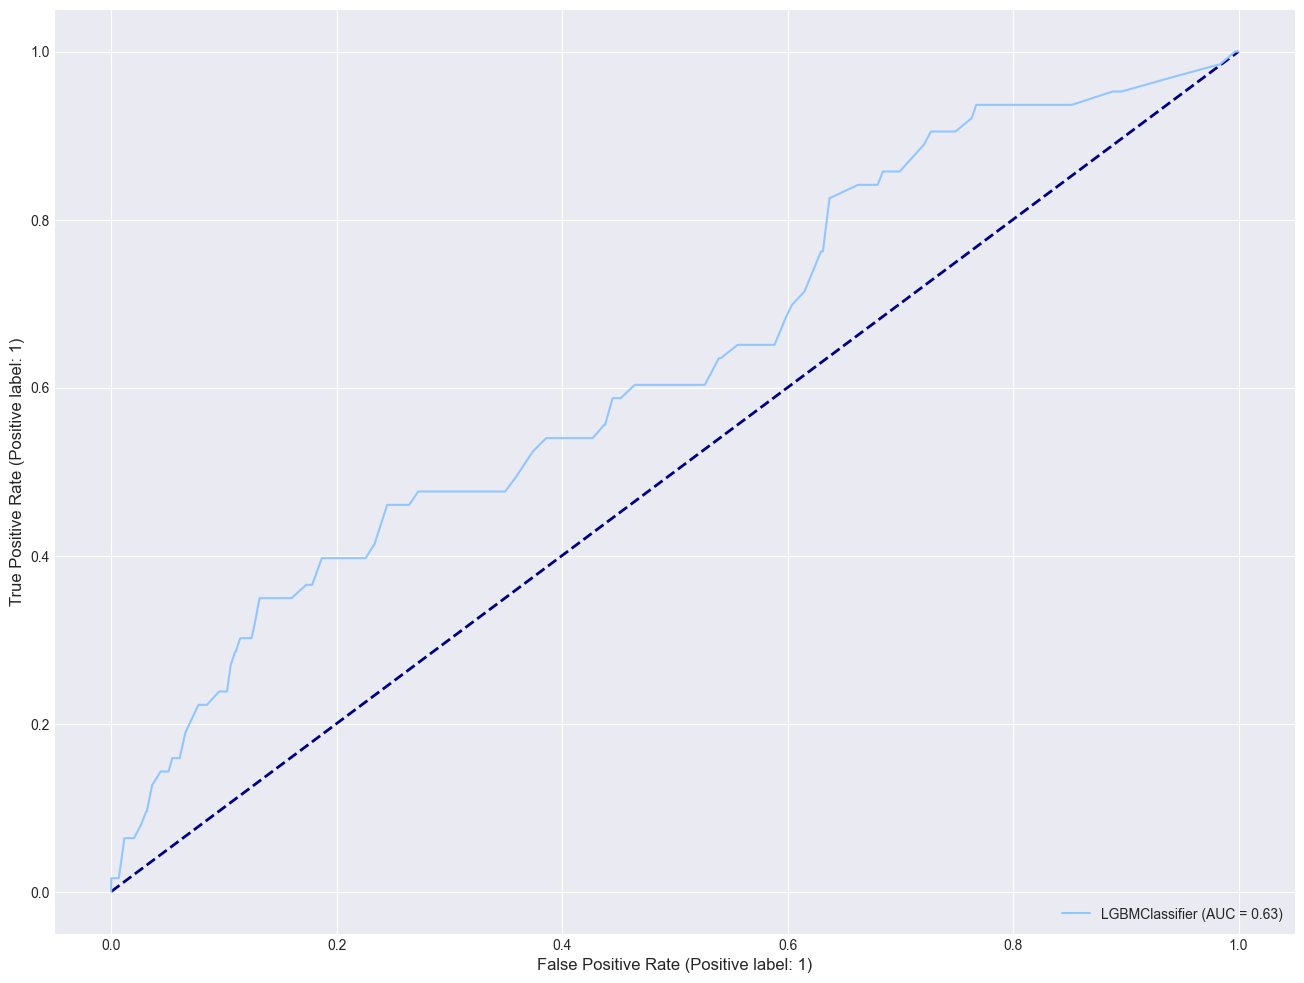

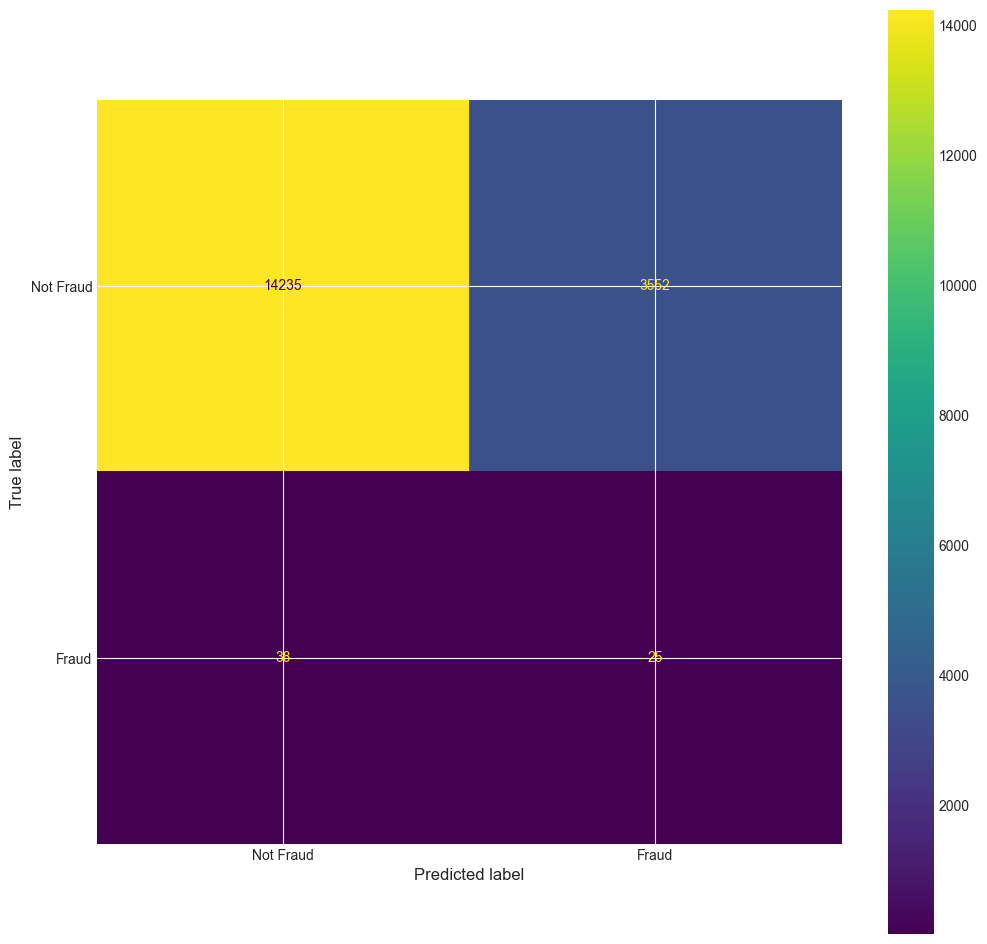

'f88a3574ea5245f28a1b6560d6bb2b2f'

In [74]:
exp_name = "LightGBM_autolog_Fraud_Model"
main_path = os.path.dirname(os.path.abspath('model.ipynb'))
mlflow_model(exp_name,df,tuned_params,main_path)

In [75]:
change_stage(exp_name,1,'Production')
predict(df,exp_name,1)

X train set size: (36240, 3);
X test set size: (17850, 3); 
y train set size: (36240,);
y test set size: (17850,);


array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [76]:
# Fuction to get model versions
def search_model(model_name):
    client = MlflowClient()
    for mv in client.search_model_versions(f"name='{model_name}'"):
        model_v = f"models:/{model_name}/{mv.version}"
        model_s = f"models:/{model_name}/production"
        # Get URI of the model
        model_uri = "runs:/{}/model".format(mv.run_id)
        print(dict(mv))
        return model_v,model_s,model_uri

In [77]:
search_model(exp_name)

{'creation_timestamp': 1679602581932, 'current_stage': 'Production', 'description': 'Model to predict fraud transactions', 'last_updated_timestamp': 1679602582896, 'name': 'LightGBM_autolog_Fraud_Model', 'run_id': 'f88a3574ea5245f28a1b6560d6bb2b2f', 'run_link': None, 'source': 'file:///d:/UNAL/Master%20Anal%C3%ADtica/2023-1S/Producto%20de%20Datos/Trabajos/ProcesamientoDatos/mlruns/743371455761528284/f88a3574ea5245f28a1b6560d6bb2b2f/artifacts/model', 'status': 'READY', 'status_message': None, 'tags': {}, 'user_id': None, 'version': 1}


('models:/LightGBM_autolog_Fraud_Model/1',
 'models:/LightGBM_autolog_Fraud_Model/production',
 'runs:/f88a3574ea5245f28a1b6560d6bb2b2f/model')

In [78]:
# Create an API to serve the model using Docker
# export MLFLOW_TRACKING_URI = http://localhost:5000
# mlflow models serve -m "models:/LightGBM_autolog_Fraud_Model/production"
# mlflow models serve -m "models:/LightGBM_autolog_Fraud_Model/Production" --port 5000
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0
# mlflow models serve --model-uri runs:/f88a3574ea5245f28a1b6560d6bb2b2f/model --no-conda

In [ ]:
import requests
import json
X, y = get_variables(df)
X_train, X_test, y_train, y_test = make_train_test_split(X,y)
url= "http://127.0.0.1:5000/invocations"
headers = {"Content-Type": "application/json"}
data = X_test[0:1000].to_json(orient='split')
response = requests.post(url,data,headers=headers)
response

In [ ]:
# Request the model to the MLflow API
!curl http://127.0.0.1:5000/ajax-api/2.0/mlflow/registered-models/get?name=LightGBM_autolog_Fraud_Model


In [ ]:
# Call the API
!curl http://127.0.0.1:5000/invocations -H 'Content-Type: application/json' -d {data}